In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import neural_CV
import utils
import network 

In [3]:
MEAN = 1.0
STD = 2.0 

def integrand(x):  
    return x 

# target dist
dist = torch.distributions.Normal(MEAN, STD)

# gaussian logprob
def logprob(x):
    return dist.log_prob(x)

In [4]:
# for a given value of c, the solution to the differential equation:
# d/dx g(x) + d/dx logprob(x) * g(x) = x - c
# for logprob(x) = -1/2 * (x - MEAN)**2 / STD**2
# is g(x) = 
# this is the general solution ! 
def true_g(x,c,k = 0.):
    return np.sqrt( 2 * np.pi) * (1. - c) * torch.erf((x - 1.)/(np.sqrt(2) * 2.)) * torch.exp((1/8)*(x-1.)**2) - 4 + k*torch.exp((1/4)*(x**2 / 2 - x))

In [5]:
# want to check if ncv training converges to correct value
# for the integral of x over a gaussian distribution

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# alternative to estimating moment without using c
# I think, that as c is trained to optimality it should converge to this number ! 
# check this!
def est_moment(stein_val, h_sample):
    return ((h_sample - stein_val)).mean()

# to train neural CV
def train_network_ncv_loss(net, c, optimizer, optim_c, sample, target_dist, h, epochs, reg = 0., verbose=True, mb_size = None, train_c_opt = True):
    sample = sample.to(device)

    net = net.to(device)
    c = c.to(device)

    losses = []
    errors_soln_c = []

    # precompute h(sample) and logp(sample)
    h_sample = h(sample).detach().to(device)

    logp_sample = target_dist.log_prob(sample)
    score_sample = utils.get_grad(logp_sample.sum(), sample).detach()
    
    # data minibatches
    # full batch 
    if mb_size is None:
        batch_idx = torch.arange(0,sample.size(0)).long()
        mb_size = sample.size(0)
    else:
        print("**Minibatches with batch size: ", mb_size)
        batch_idx = torch.randperm(sample.size(0))

    for e in tqdm(range(epochs), desc='Training '):
        epoch_loss = 0.

        # initialize c properly
        c.data = est_moment(neural_CV.stein_g_precomputed_score(sample, net, score_sample), h_sample)

        for b_num in range(0, sample.size(0), mb_size):
            idx = batch_idx[b_num: b_num + mb_size]

            # get minibatch vals
            sample_mb = sample[idx, :]
            h_sample_mb = h_sample[idx]

            optimizer.zero_grad()
            optim_c.zero_grad()

            stein_val = neural_CV.stein_g_precomputed_score(sample_mb, net, score_sample)

            #print(f'Stein val shape: {stein_val.shape}')
            #print(f'H sample shape: {h_sample.shape}')
              
            assert(stein_val.shape == h_sample_mb.shape)
            assert(stein_val.device == h_sample_mb.device)

            loss = torch.mean((stein_val + c.detach() - h_sample_mb)**2)

            if reg > 0.:
                loss += reg * (net(sample_mb)**2).mean()

            loss.backward()
            optimizer.step()
            optim_c.step() 
            
            epoch_loss += loss.item()/sample.size(0)

        # track loss each epoch
        losses.append(epoch_loss)    
        error_soln_c = ((net(sample).detach() - true_g(sample, c))**2).mean().item()
        errors_soln_c.append(error_soln_c)

        if verbose:
            if e % 100 == 0:  
                
                print(f'Epoch [{e}/{epochs}], Loss: {epoch_loss}, Error soln_c: {error_soln_c}, c value: {c.item()}, Est moment (Stein-val - h): {est_moment(stein_val, h_sample)}')

                if train_c_opt:

                    print("\nTraining c to convergence")
                    
                    # maybe if you have minibatches, then training c can help
                    # otherwise I see no reason not to just set it to its converged value (like here)
                    c.data = est_moment(stein_val, h_sample)

                    print(f'c value: {c.item()}')
                    print(f'Est moment (Stein-val - h): {est_moment(stein_val, h_sample)}, MC estimate: {h_sample.mean()}')


                    # iterate training of c until it converges
                    #for i in range(1000):
                        
                        #optim_c.zero_grad()
                        #loss_c = torch.mean((stein_val.detach() + c - h_sample)**2)
                        #loss_c.backward()
                        #optim_c.step()

                        #print(f'c value: {c.item()}')
                        #print(f'Est moment (Stein-val - h): {est_moment(stein_val, h_sample)}, MC estimate: {h_sample.mean()}')

    return net, c, losses, errors_soln_c  

In [15]:
# train with Neural Stein
def train_neural_stein(net, optimizer, sample, target_dist, h, epochs, verbose = True, mb_size = None, multiparticle = False):

    sample = sample.to(device)

    #perturbed samples
    sample_bar = (sample + torch.randn_like(sample)).to(device)

    net = net.to(device)

    # precompute h(sample) and logp(sample)
    h_sample = h(sample).detach().to(device)

    h_sample_bar = h(sample_bar).detach().to(device)

    logp_sample = target_dist.log_prob(sample)
    score_sample = utils.get_grad(logp_sample.sum(), sample).detach()

    logp_sample_bar = target_dist.log_prob(sample_bar)
    score_sample_bar = utils.get_grad(logp_sample_bar.sum(), sample_bar).detach()

    # data minibatches
    # full batch 
    if mb_size is None:
        batch_idx = torch.arange(0,sample.size(0)).long()
        mb_size = sample.size(0) 
    else:
        print("**Minibatches with batch size: ", mb_size)
        batch_idx = torch.randperm(sample.size(0))

    # for logging
    losses = []
    errors_soln_c = []

    for e in tqdm(range(epochs), desc='Training '):
        epoch_loss = 0.

        for b_num in range(0, sample.size(0), mb_size):
            idx = batch_idx[b_num: b_num + mb_size]

            # get minibatch vals
            sample_mb = sample[idx, :]
            sample_bar_mb = sample_bar[idx,:]

            h_sample_mb = h_sample[idx]
            h_sample_bar_mb = h_sample_bar[idx]

            score_sample_mb = score_sample[idx,:]
            score_sample_bar_mb = score_sample_bar[idx,:]

            # loss and training             
            optimizer.zero_grad()

            stein_val = neural_CV.stein_g_precomputed_score(sample_mb, net, score_sample_mb)
            stein_val_bar = neural_CV.stein_g_precomputed_score(sample_bar_mb, net, score_sample_bar_mb)

            #print(f'Stein val shape: {stein_val.shape}')
            #print(f'H sample shape: {h_sample.shape}')
              
            assert(stein_val.shape == h_sample_mb.shape), f"Stein val shape: {stein_val.shape}, H sample shape: {h_sample_mb.shape}"
            assert(stein_val.device == h_sample_mb.device)

            if multiparticle:
                loss = (torch.mean(stein_val - h_sample_mb) - torch.mean(stein_val_bar - h_sample_bar_mb))**2
            else:
                loss = torch.mean(( (stein_val - h_sample_mb) - (stein_val_bar - h_sample_bar_mb))**2)
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()/sample.size(0)
        
        # track loss each epoch
        losses.append(epoch_loss)    
        error_soln_c = ((net(sample).detach() - true_g(sample, 1.))**2).mean().item()
        errors_soln_c.append(error_soln_c)
        
        stein_val = neural_CV.stein_g_precomputed_score(sample, net, score_sample)
        est_moment_val = est_moment(stein_val, h_sample)

        if verbose:
            if e % 100 == 0:  
                print(f'Epoch [{e}/{epochs}], Loss: {epoch_loss}, Est Moment: {est_moment_val}, Error soln_c (on samples): {error_soln_c}')
    return net, losses, errors_soln_c 


In [7]:
# train with var min objective - ie. pass gradient through mean as well
# no c this time 

def train_network_var_min(net, optimizer, sample, target_dist, h, epochs, reg = 0., verbose=True, mb_size = None):
    sample = sample.to(device)

    net = net.to(device)

    losses = []
    errors_soln_c = []

    # precompute h(sample) and logp(sample)
    h_sample = h(sample).detach().to(device)

    logp_sample = target_dist.log_prob(sample)
    score_sample = utils.get_grad(logp_sample.sum(), sample).detach()
    
    # data minibatches
    # full batch 
    if mb_size is None:
        batch_idx = torch.arange(0,sample.size(0)).long()
        mb_size = sample.size(0)
    else:
        print("**Minibatches with batch size: ", mb_size)
        batch_idx = torch.randperm(sample.size(0))

    for e in tqdm(range(epochs), desc='Training '):
        epoch_loss = 0.

        for b_num in range(0, sample.size(0), mb_size):
            idx = batch_idx[b_num: b_num + mb_size]

            # get minibatch vals
            sample_mb = sample[idx, :]
            h_sample_mb = h_sample[idx]

            optimizer.zero_grad()

            stein_val = neural_CV.stein_g_precomputed_score(sample_mb, net, score_sample)

            #print(f'Stein val shape: {stein_val.shape}')
            #print(f'H sample shape: {h_sample.shape}')
              
            assert(stein_val.shape == h_sample_mb.shape)
            assert(stein_val.device == h_sample_mb.device)

            # need to be differentiable wrt g here in mean as well
            # this is the key difference from the "train g" then "train c" alternatingly method above
            est_mean = (stein_val - h_sample_mb).mean()

            # empirical variance (note: NOT unbiased variance estimator)
            loss = torch.mean((stein_val - h_sample_mb - est_mean)**2)

            if reg > 0.:
                loss += reg * (net(sample_mb)**2).mean()

            loss.backward()
            optimizer.step()
            
            c_val  = est_moment(stein_val, h_sample_mb).detach()
          
            epoch_loss += loss.item()/sample.size(0)

        # track loss each epoch
        losses.append(epoch_loss)    

        #error_soln_c = ((net(sample).detach() - true_g(sample, c_val))**2).mean().item()
        error_soln_c = ((net(sample).detach() - true_g(sample, 1.0))**2).mean().item()
        
        errors_soln_c.append(error_soln_c)

        if verbose:
            if e % 100 == 0:  
                print(f'Epoch [{e}/{epochs}], Loss: {epoch_loss}, Error g_c: {error_soln_c}, Est moment (Stein-val - h): {est_moment(stein_val, h_sample)}, MC est: {h_sample.mean()}')

    return net, losses, errors_soln_c 

In [12]:
def train(seed = 1, epochs = 1000, gt = False, type = "var_min", multiparticle = False):
    
    #set seeds for repro
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    if gt:
        # sample from gaussian
        samples = dist.sample((100,1))
    else:
        # off samples
        samples = dist.sample((100,1)) - 4.0
        samples2 = samples + torch.randn_like(samples)
        samples = torch.cat([samples, samples2], dim = 0)
    samples.requires_grad = True 

    net = network.MLP(n_dims=1, n_out=1)
    net = torch.nn.DataParallel(net)

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

    if type == "var_min":
        net, losses, errors_g = train_network_var_min(net, 
                           optimizer, sample = samples, 
                           target_dist = dist, 
                           h = integrand, epochs = epochs, 
                           reg = 0., verbose=True, 
                           mb_size = None)
        loss_str = "Var Min Loss"
    elif type == "neural_cv":
        c = torch.tensor(0.0, requires_grad=True)
        optim_c = torch.optim.Adam([c], lr=1e-3)
        
        # train neural CV
        net, c, losses, errors_g = train_network_ncv_loss(net, c, 
                           optimizer, 
                           optim_c, sample = samples, 
                           target_dist = dist, 
                           h = integrand, epochs = epochs, 
                           reg = 0., verbose=True, 
                           mb_size = None)
        loss_str = "NCV Loss"
    elif type == "neural_stein":
        net, losses, errors_g = train_neural_stein(net,
                                optimizer, sample = samples, 
                                target_dist = dist, 
                                h = integrand, epochs = epochs, 
                                verbose=True, 
                                mb_size = None,
                                multiparticle = multiparticle)
        loss_str = "NeuralStein Diff Loss"
    if gt:
        gt_str = "Ground Truth"
    else:
        gt_str = "Off Sample"


    plt.plot(losses, label  = loss_str)
    plt.legend(loc='best')
    plt.title("{} Training {}".format(gt_str, loss_str))
    plt.show()

    plt.plot(errors_g, label = "Error g (at each c)")
    plt.legend(loc='best')
    plt.title("{} {} Error from Solution to ODE_c".format(gt_str, loss_str))
    plt.show()

    if type == "var_min":
        stein_vals = neural_CV.stein_g(samples.to(device), net.to(device), dist.log_prob).to(samples.device)
        h_vals = integrand(samples)
        c_val = est_moment(stein_vals, h_vals).detach().item()
    elif type == "neural_cv":
        c_val = c.detach().item()   
    elif type == "neural_stein":
        c_val = 1.0

    # plot net vs true g
    x = torch.linspace(-10,10,100).view(-1,1)
    
    plt.figure()
    plt.plot(x.detach().numpy(), net(x.to(device)).detach().cpu(), label = "Net g(x)")
    plt.plot(x.detach().numpy(), true_g(x, c_val).detach().cpu(), label = "True g(x)")
    plt.legend(loc='best')
    plt.title("g(x) vs True g(x) for c = {}".format(c_val))
    plt.show()

    # plot zoomed in net vs true g
    x_zoom = torch.linspace(-3,3,100).view(-1,1)
    plt.figure()
    plt.plot(x_zoom.detach().numpy(), net(x_zoom.to(device)).detach().cpu(), label = "Net g(x)")
    plt.plot(x_zoom.detach().numpy(), true_g(x_zoom, c_val).detach().cpu(), label = "True g(x)")
    plt.legend(loc='best')
    plt.title("Zoomed g(x) vs True g(x) for c = {}".format(c_val))
    plt.show()

    plt.figure()
    plt.plot(x.detach().numpy(), net(x.to(device)).detach().cpu(), label = "Net g(x)")
    plt.title("Net g(x)")
    plt.show()

Training :   2%|▏         | 16/1000 [00:00<00:33, 29.37it/s]

Epoch [0/1000], Loss: 0.03729498147964477, Error g_c: 723.6749877929688, Est moment (Stein-val - h): 0.5964349508285522, MC est: 0.5946288108825684


Training :  12%|█▏        | 122/1000 [00:01<00:06, 134.04it/s]

Epoch [100/1000], Loss: 3.945413627661765e-06, Error g_c: 0.0022742529399693012, Est moment (Stein-val - h): 1.0005050897598267, MC est: 0.5946288108825684


Training :  23%|██▎       | 227/1000 [00:02<00:05, 143.26it/s]

Epoch [200/1000], Loss: 9.898880307446234e-08, Error g_c: 1.8307981008547358e-05, Est moment (Stein-val - h): 0.9999516010284424, MC est: 0.5946288108825684


Training :  32%|███▏      | 317/1000 [00:02<00:04, 145.07it/s]

Epoch [300/1000], Loss: 3.955462489102501e-08, Error g_c: 7.468749390682206e-05, Est moment (Stein-val - h): 0.9998723864555359, MC est: 0.5946288108825684


Training :  42%|████▏     | 423/1000 [00:03<00:03, 148.38it/s]

Epoch [400/1000], Loss: 2.7400294584367658e-08, Error g_c: 0.00011835428449558094, Est moment (Stein-val - h): 0.9998373985290527, MC est: 0.5946288108825684


Training :  53%|█████▎    | 528/1000 [00:04<00:03, 146.60it/s]

Epoch [500/1000], Loss: 2.4709593162697275e-08, Error g_c: 0.00012142489867983386, Est moment (Stein-val - h): 0.9998354315757751, MC est: 0.5946288108825684


Training :  62%|██████▏   | 618/1000 [00:04<00:02, 145.54it/s]

Epoch [600/1000], Loss: 2.3159402644523653e-08, Error g_c: 0.0001052660882123746, Est moment (Stein-val - h): 0.999847412109375, MC est: 0.5946288108825684


Training :  72%|███████▏  | 723/1000 [00:05<00:01, 140.74it/s]

Epoch [700/1000], Loss: 2.1710670807806308e-08, Error g_c: 8.529698970960453e-05, Est moment (Stein-val - h): 0.9998635649681091, MC est: 0.5946288108825684


Training :  83%|████████▎ | 828/1000 [00:06<00:01, 142.42it/s]

Epoch [800/1000], Loss: 2.0296142793085893e-08, Error g_c: 6.649611168541014e-05, Est moment (Stein-val - h): 0.9998807311058044, MC est: 0.5946288108825684


Training :  92%|█████████▏| 918/1000 [00:06<00:00, 140.94it/s]

Epoch [900/1000], Loss: 1.892573777695361e-08, Error g_c: 5.020311800763011e-05, Est moment (Stein-val - h): 0.9998978972434998, MC est: 0.5946288108825684


Training : 100%|██████████| 1000/1000 [00:07<00:00, 132.13it/s]


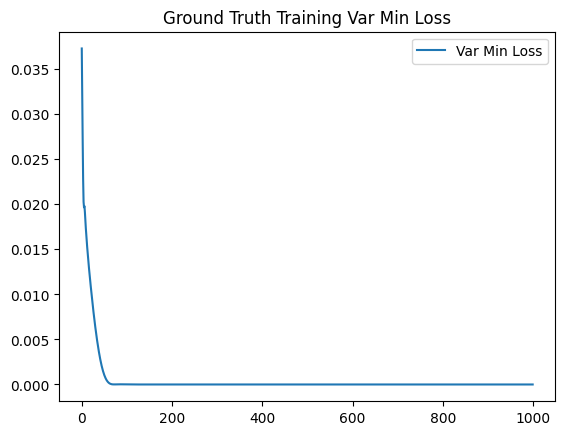

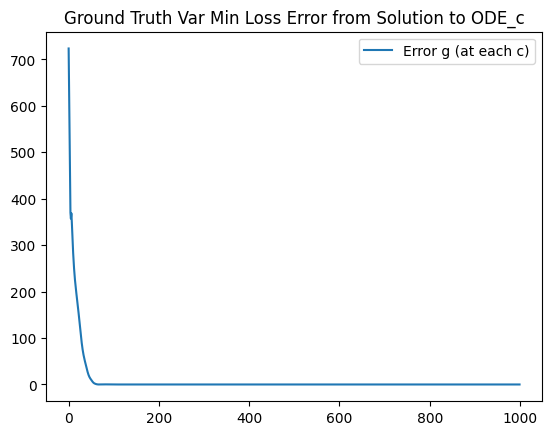

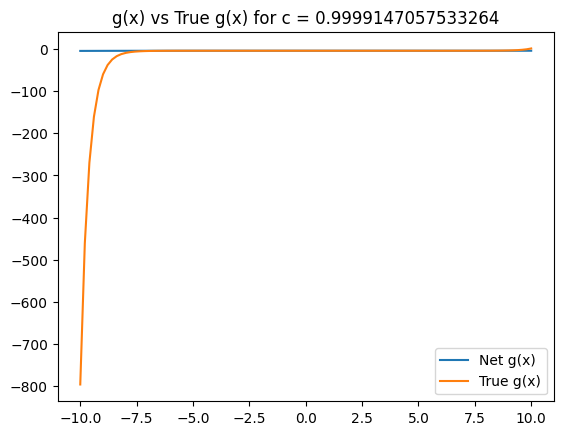

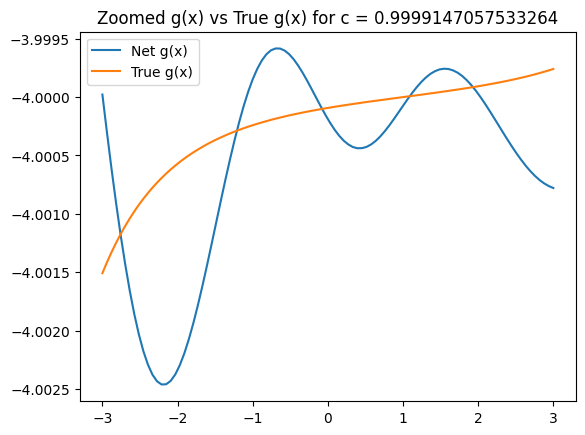

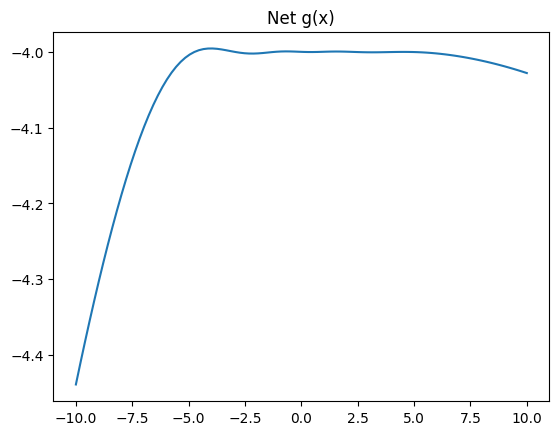

In [9]:
train(gt = True, type = "var_min")

Training :   3%|▎         | 29/1000 [00:00<00:06, 150.82it/s]

Epoch [0/1000], Loss: 0.038901872634887695, Error g_c: 9991391232.0, Est moment (Stein-val - h): -2.4055845737457275, MC est: -2.4053709506988525


Training :  12%|█▏        | 122/1000 [00:00<00:04, 179.79it/s]

Epoch [100/1000], Loss: 0.00015964420512318611, Error g_c: 2089245312.0, Est moment (Stein-val - h): -0.557303249835968, MC est: -2.4053709506988525


Training :  24%|██▍       | 239/1000 [00:01<00:04, 188.60it/s]

Epoch [200/1000], Loss: 3.162168199196458e-05, Error g_c: 1570976128.0, Est moment (Stein-val - h): -0.35040244460105896, MC est: -2.4053709506988525


Training :  34%|███▎      | 336/1000 [00:01<00:03, 181.69it/s]

Epoch [300/1000], Loss: 1.1955079389736057e-05, Error g_c: 1293841024.0, Est moment (Stein-val - h): -0.22551581263542175, MC est: -2.4053709506988525


Training :  43%|████▎     | 430/1000 [00:02<00:03, 174.52it/s]

Epoch [400/1000], Loss: 7.3890306521207095e-06, Error g_c: 1211606656.0, Est moment (Stein-val - h): -0.18593047559261322, MC est: -2.4053709506988525


Training :  53%|█████▎    | 526/1000 [00:02<00:02, 185.90it/s]

Epoch [500/1000], Loss: 3.108442761003971e-06, Error g_c: 1017373056.0, Est moment (Stein-val - h): -0.0867222398519516, MC est: -2.4053709506988525


Training :  62%|██████▏   | 623/1000 [00:03<00:01, 188.52it/s]

Epoch [600/1000], Loss: 1.8994585843756795e-06, Error g_c: 947044480.0, Est moment (Stein-val - h): -0.04848843812942505, MC est: -2.4053709506988525


Training :  72%|███████▏  | 718/1000 [00:03<00:01, 180.25it/s]

Epoch [700/1000], Loss: 1.6807069187052548e-06, Error g_c: 910137216.0, Est moment (Stein-val - h): -0.02785516157746315, MC est: -2.4053709506988525


Training :  83%|████████▎ | 832/1000 [00:04<00:00, 177.31it/s]

Epoch [800/1000], Loss: 1.0807916260091588e-06, Error g_c: 851742656.0, Est moment (Stein-val - h): 0.005665205419063568, MC est: -2.4053709506988525


Training :  92%|█████████▎| 925/1000 [00:05<00:00, 177.39it/s]

Epoch [900/1000], Loss: 8.475940558128059e-07, Error g_c: 791688320.0, Est moment (Stein-val - h): 0.04135987162590027, MC est: -2.4053709506988525


Training : 100%|██████████| 1000/1000 [00:05<00:00, 179.81it/s]


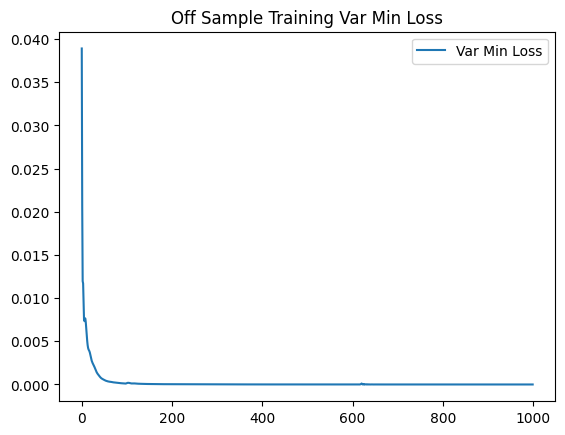

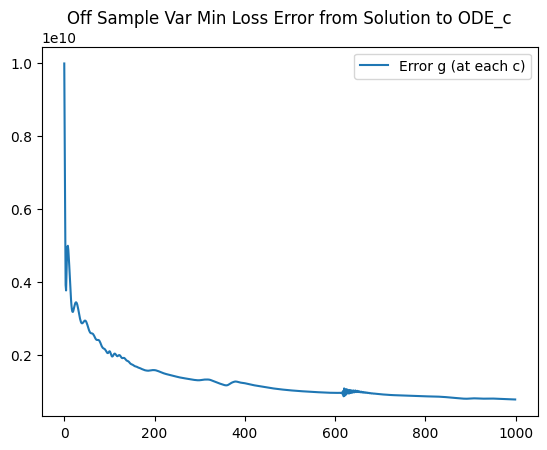

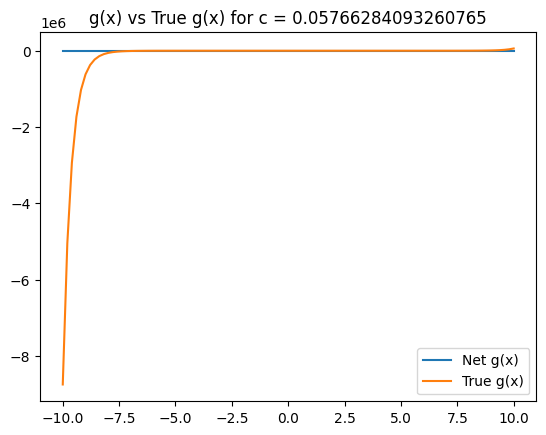

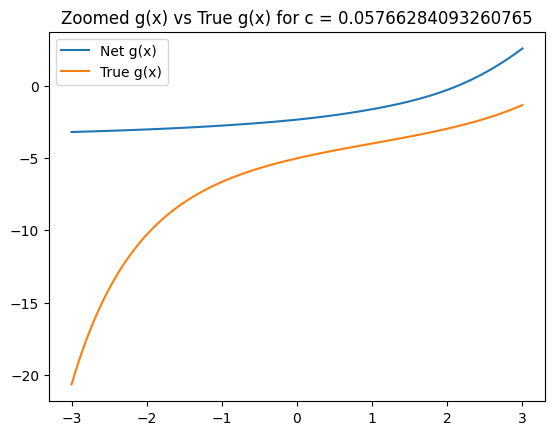

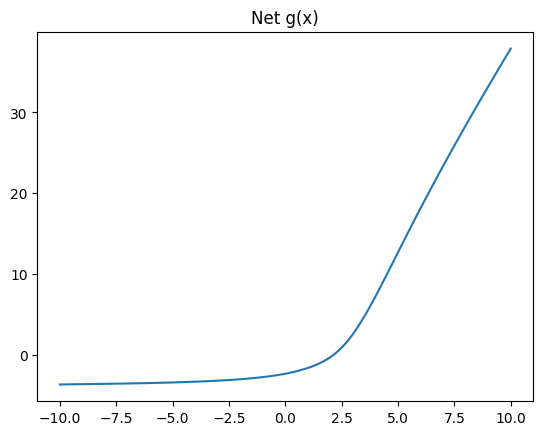

In [25]:
train(gt =False, type = "var_min")

Training :   3%|▎         | 34/1000 [00:00<00:05, 167.25it/s]

Epoch [0/1000], Loss: 0.01983135461807251, Error g_c: 9.117425918579102, Est moment (Stein-val - h): -3.2718327045440674, MC est: -3.40505313873291


Training :  12%|█▏        | 119/1000 [00:00<00:05, 163.74it/s]

Epoch [100/1000], Loss: 6.160035729408265e-05, Error g_c: 4.305387496948242, Est moment (Stein-val - h): -0.8378881812095642, MC est: -3.40505313873291


Training :  22%|██▏       | 224/1000 [00:01<00:04, 165.81it/s]

Epoch [200/1000], Loss: 1.596849993802607e-05, Error g_c: 3.518115997314453, Est moment (Stein-val - h): -0.6552954912185669, MC est: -3.40505313873291


Training :  32%|███▏      | 324/1000 [00:02<00:04, 159.02it/s]

Epoch [300/1000], Loss: 6.629295530728995e-06, Error g_c: 3.079233407974243, Est moment (Stein-val - h): -0.5497878789901733, MC est: -3.40505313873291


Training :  42%|████▎     | 425/1000 [00:02<00:03, 151.34it/s]

Epoch [400/1000], Loss: 3.762190754059702e-06, Error g_c: 2.9007976055145264, Est moment (Stein-val - h): -0.5057238936424255, MC est: -3.40505313873291


Training :  53%|█████▎    | 528/1000 [00:03<00:02, 162.85it/s]

Epoch [500/1000], Loss: 2.5835412088781596e-06, Error g_c: 2.7890853881835938, Est moment (Stein-val - h): -0.47729405760765076, MC est: -3.40505313873291


Training :  62%|██████▏   | 617/1000 [00:03<00:02, 162.74it/s]

Epoch [600/1000], Loss: 1.82692107046023e-06, Error g_c: 2.6823370456695557, Est moment (Stein-val - h): -0.44955503940582275, MC est: -3.40505313873291


Training :  72%|███████▏  | 718/1000 [00:04<00:01, 162.84it/s]

Epoch [700/1000], Loss: 1.3766031770501285e-06, Error g_c: 2.6117076873779297, Est moment (Stein-val - h): -0.42174944281578064, MC est: -3.40505313873291


Training :  82%|████████▏ | 823/1000 [00:05<00:01, 163.42it/s]

Epoch [800/1000], Loss: 9.9218035757076e-07, Error g_c: 2.5024800300598145, Est moment (Stein-val - h): -0.40133166313171387, MC est: -3.40505313873291


Training :  93%|█████████▎| 932/1000 [00:05<00:00, 166.19it/s]

Epoch [900/1000], Loss: 7.442665082635358e-07, Error g_c: 2.4696261882781982, Est moment (Stein-val - h): -0.39220985770225525, MC est: -3.40505313873291


Training : 100%|██████████| 1000/1000 [00:06<00:00, 161.46it/s]


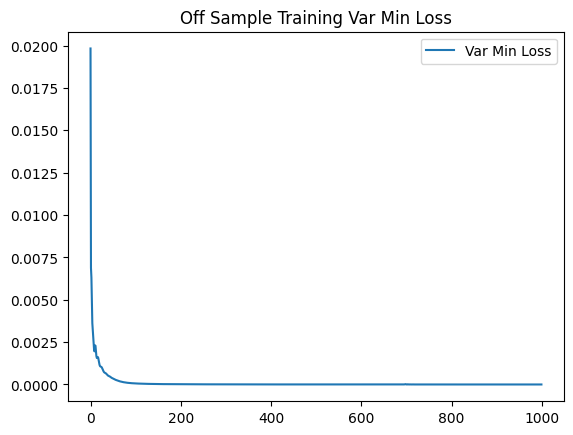

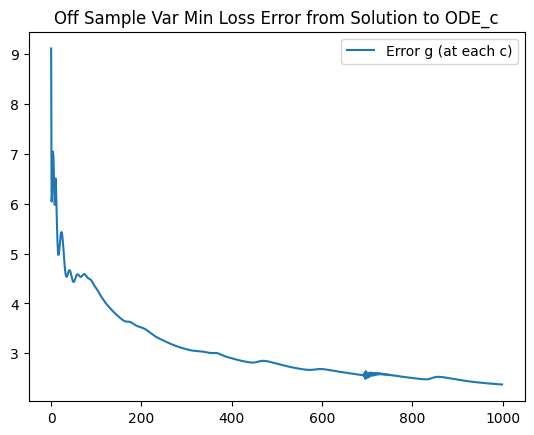

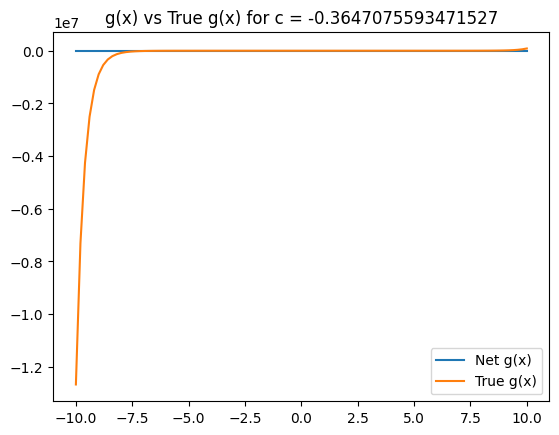

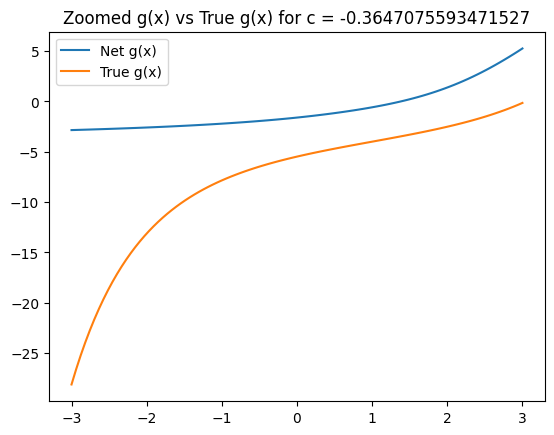

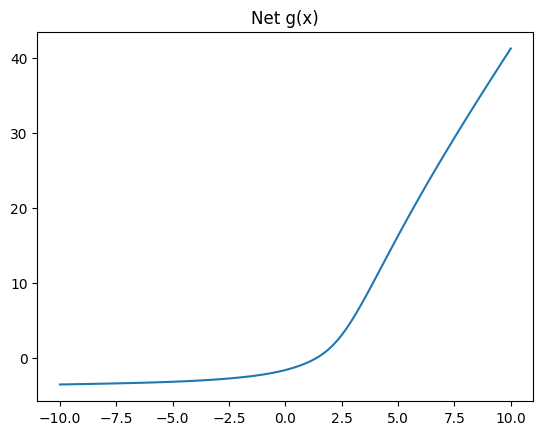

In [33]:
# with sample_bar included
train(gt =False, type = "var_min")

### With Neural Stein 

### Single particle diff loss

Training :   2%|▏         | 19/1000 [00:00<00:10, 92.44it/s]

Epoch [0/1000], Loss: 0.012664099931716919, Est Moment: 0.6070674657821655, Error soln_c (on samples): 14.401196479797363


Training :  11%|█         | 112/1000 [00:01<00:09, 95.94it/s]

Epoch [100/1000], Loss: 6.821526039857417e-07, Est Moment: 1.001434564590454, Error soln_c (on samples): 0.00042890672921203077


Training :  22%|██▏       | 215/1000 [00:02<00:07, 99.99it/s]

Epoch [200/1000], Loss: 4.756734597322065e-08, Est Moment: 1.0002291202545166, Error soln_c (on samples): 1.6806261555757374e-05


Training :  32%|███▏      | 318/1000 [00:03<00:07, 91.77it/s] 

Epoch [300/1000], Loss: 3.0407814847421834e-07, Est Moment: 1.0009269714355469, Error soln_c (on samples): 0.00015460411668755114


Training :  41%|████      | 411/1000 [00:04<00:06, 94.71it/s]

Epoch [400/1000], Loss: 2.8862978069810197e-08, Est Moment: 1.0002161264419556, Error soln_c (on samples): 9.820642844715621e-06


Training :  52%|█████▏    | 516/1000 [00:05<00:05, 93.87it/s] 

Epoch [500/1000], Loss: 2.817169006448239e-06, Est Moment: 0.9994836449623108, Error soln_c (on samples): 9.486657654633746e-05


Training :  62%|██████▏   | 617/1000 [00:06<00:03, 96.05it/s]

Epoch [600/1000], Loss: 1.74808315023256e-08, Est Moment: 1.000194787979126, Error soln_c (on samples): 5.689226327376673e-06


Training :  72%|███████▏  | 717/1000 [00:07<00:02, 94.62it/s]

Epoch [700/1000], Loss: 1.3155673741493956e-08, Est Moment: 1.0001683235168457, Error soln_c (on samples): 4.30482350566308e-06


Training :  82%|████████▏ | 821/1000 [00:08<00:01, 98.12it/s]

Epoch [800/1000], Loss: 5.734993465011939e-08, Est Moment: 1.0002169609069824, Error soln_c (on samples): 3.877884410030674e-06


Training :  91%|█████████▏| 913/1000 [00:09<00:00, 93.00it/s]

Epoch [900/1000], Loss: 7.172111509134993e-09, Est Moment: 1.0001286268234253, Error soln_c (on samples): 2.3336856429523323e-06


Training : 100%|██████████| 1000/1000 [00:10<00:00, 93.72it/s]


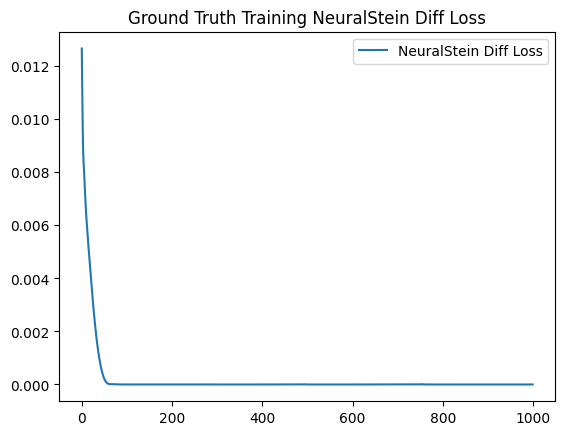

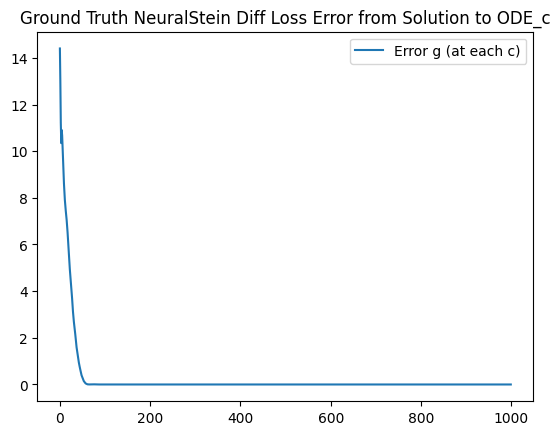

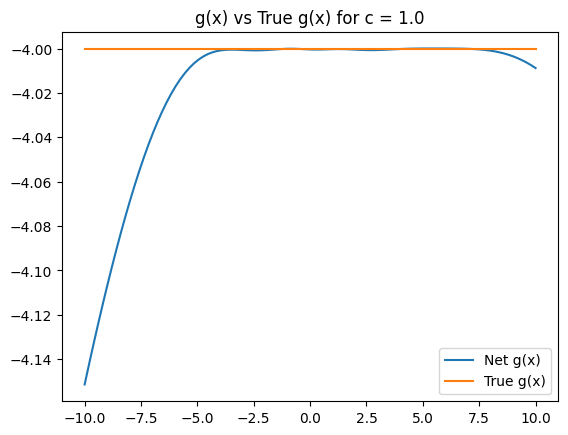

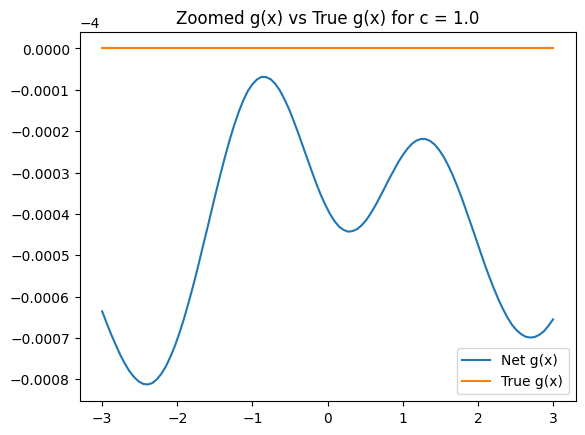

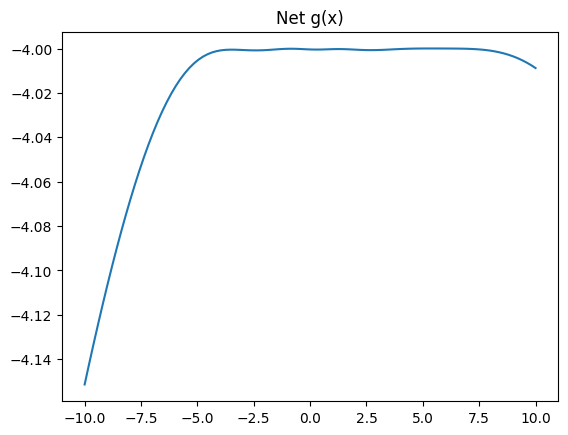

In [17]:
train(gt = True, type = "neural_stein")

Training :   0%|          | 0/1000 [00:00<?, ?it/s]

Training :   2%|▏         | 18/1000 [00:00<00:11, 87.79it/s]

Epoch [0/1000], Loss: 0.004678398668766022, Est Moment: -2.3669087886810303, Error soln_c (on samples): 9.600151062011719


Training :  11%|█         | 111/1000 [00:01<00:11, 80.13it/s]

Epoch [100/1000], Loss: 0.00010284465737640858, Est Moment: 0.054837845265865326, Error soln_c (on samples): 0.8834184408187866


Training :  21%|██        | 210/1000 [00:02<00:09, 80.93it/s]

Epoch [200/1000], Loss: 3.38406243827194e-08, Est Moment: 0.9887768626213074, Error soln_c (on samples): 0.00017249969823751599


Training :  31%|███       | 312/1000 [00:03<00:08, 79.75it/s]

Epoch [300/1000], Loss: 1.2861430604971246e-08, Est Moment: 0.9983760118484497, Error soln_c (on samples): 8.277512824861333e-05


Training :  42%|████▏     | 415/1000 [00:04<00:06, 86.78it/s]

Epoch [400/1000], Loss: 6.354841025313363e-07, Est Moment: 0.9937933683395386, Error soln_c (on samples): 0.0001016563837765716


Training :  52%|█████▏    | 518/1000 [00:06<00:05, 91.01it/s]

Epoch [500/1000], Loss: 5.972011081212258e-09, Est Moment: 0.9922224283218384, Error soln_c (on samples): 7.357985305134207e-05


Training :  61%|██████▏   | 614/1000 [00:07<00:04, 84.37it/s]

Epoch [600/1000], Loss: 1.023334789351793e-08, Est Moment: 0.9970425367355347, Error soln_c (on samples): 4.078596248291433e-05


Training :  72%|███████▏  | 717/1000 [00:08<00:03, 87.05it/s]

Epoch [700/1000], Loss: 5.404343710324611e-09, Est Moment: 0.9923974871635437, Error soln_c (on samples): 6.963330088183284e-05


Training :  82%|████████▏ | 817/1000 [00:09<00:02, 82.80it/s]

Epoch [800/1000], Loss: 5.018167712478316e-09, Est Moment: 0.9924421310424805, Error soln_c (on samples): 6.720613600919023e-05


Training :  91%|█████████▏| 913/1000 [00:10<00:01, 86.75it/s]

Epoch [900/1000], Loss: 5.519206638382457e-09, Est Moment: 0.9922254681587219, Error soln_c (on samples): 6.968255183892325e-05


Training : 100%|██████████| 1000/1000 [00:11<00:00, 84.85it/s]


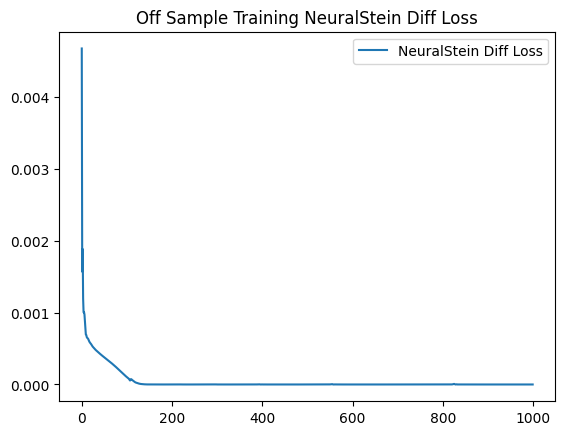

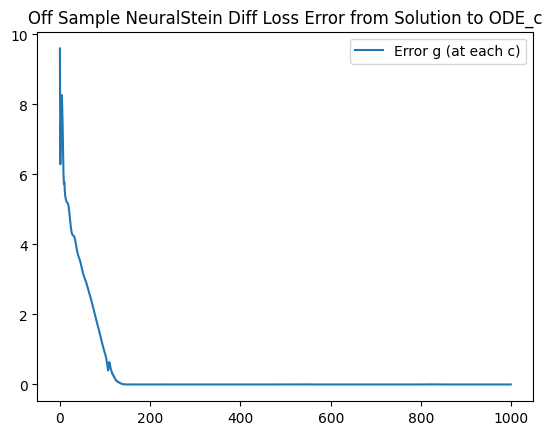

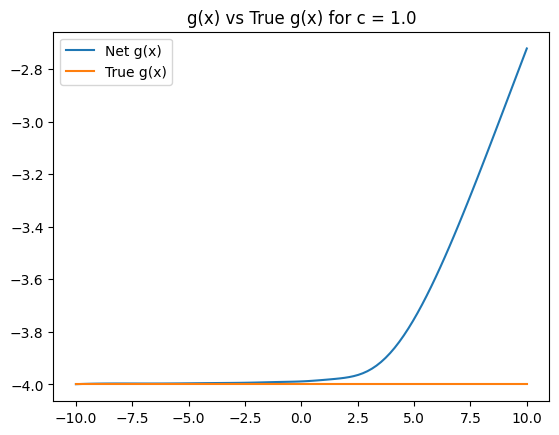

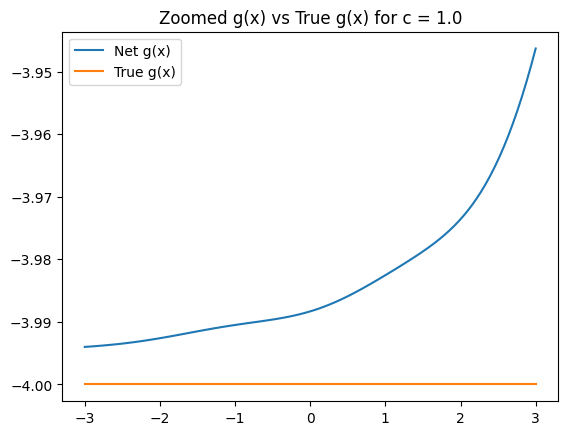

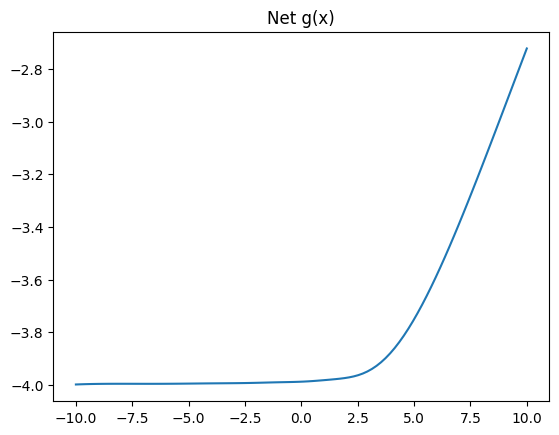

In [34]:
train(gt = False, type = "neural_stein")

Training :   1%|          | 19/3000 [00:00<00:33, 89.34it/s]

Epoch [0/3000], Loss: 0.01301843523979187, Est Moment: -2.0386812686920166, Error soln_c (on samples): 12.524125099182129


Training :   4%|▍         | 117/3000 [00:01<00:30, 93.67it/s]

Epoch [100/3000], Loss: 0.00022245680913329124, Est Moment: 0.23897472023963928, Error soln_c (on samples): 0.8886379599571228


Training :   7%|▋         | 218/3000 [00:02<00:29, 94.67it/s]

Epoch [200/3000], Loss: 6.012729500071146e-08, Est Moment: 0.9993777275085449, Error soln_c (on samples): 1.2008809790131636e-05


Training :  10%|█         | 313/3000 [00:03<00:28, 94.85it/s]

Epoch [300/3000], Loss: 7.789976734784431e-08, Est Moment: 0.9896445870399475, Error soln_c (on samples): 0.00016707400209270418


Training :  14%|█▍        | 417/3000 [00:04<00:27, 92.35it/s]

Epoch [400/3000], Loss: 1.4286380292105605e-08, Est Moment: 0.9979391098022461, Error soln_c (on samples): 9.640781172493007e-06


Training :  17%|█▋        | 510/3000 [00:05<00:25, 98.20it/s]

Epoch [500/3000], Loss: 7.2959738872668825e-09, Est Moment: 0.9963799715042114, Error soln_c (on samples): 1.991478529816959e-05


Training :  20%|██        | 613/3000 [00:06<00:27, 88.02it/s]

Epoch [600/3000], Loss: 3.1734103345115726e-09, Est Moment: 0.9990285038948059, Error soln_c (on samples): 2.1251742055028444e-06


Training :  24%|██▍       | 718/3000 [00:07<00:22, 99.90it/s]

Epoch [700/3000], Loss: 2.9494985938072206e-08, Est Moment: 1.0001280307769775, Error soln_c (on samples): 3.965471648825769e-07


Training :  27%|██▋       | 820/3000 [00:08<00:23, 93.86it/s]

Epoch [800/3000], Loss: 1.0279860163109334e-09, Est Moment: 0.9996490478515625, Error soln_c (on samples): 3.8369367416635214e-07


Training :  30%|███       | 914/3000 [00:09<00:21, 96.30it/s]

Epoch [900/3000], Loss: 2.979429893912311e-09, Est Moment: 0.9991079568862915, Error soln_c (on samples): 1.3051597989033326e-06


Training :  34%|███▍      | 1018/3000 [00:10<00:20, 98.84it/s]

Epoch [1000/3000], Loss: 1.370887332541315e-09, Est Moment: 0.9995635747909546, Error soln_c (on samples): 4.0057477690425003e-07


Training :  37%|███▋      | 1111/3000 [00:11<00:20, 93.95it/s]

Epoch [1100/3000], Loss: 6.650711981137647e-10, Est Moment: 0.9999806880950928, Error soln_c (on samples): 6.734852320278151e-08


Training :  40%|████      | 1215/3000 [00:12<00:18, 98.77it/s]

Epoch [1200/3000], Loss: 6.531955420996383e-10, Est Moment: 0.9999793767929077, Error soln_c (on samples): 6.790381945620538e-08


Training :  44%|████▎     | 1311/3000 [00:13<00:16, 100.11it/s]

Epoch [1300/3000], Loss: 2.713495632633567e-07, Est Moment: 1.0093748569488525, Error soln_c (on samples): 0.0001656438980717212


Training :  47%|████▋     | 1421/3000 [00:14<00:15, 102.55it/s]

Epoch [1400/3000], Loss: 5.798176871962824e-10, Est Moment: 1.0001543760299683, Error soln_c (on samples): 7.067961149687108e-08


Training :  50%|█████     | 1513/3000 [00:15<00:15, 98.63it/s] 

Epoch [1500/3000], Loss: 5.48544250023042e-10, Est Moment: 1.0000786781311035, Error soln_c (on samples): 4.8866436230809995e-08


Training :  54%|█████▍    | 1616/3000 [00:16<00:13, 98.90it/s]

Epoch [1600/3000], Loss: 5.33865822660573e-10, Est Moment: 1.000040054321289, Error soln_c (on samples): 4.4775767094051844e-08


Training :  57%|█████▋    | 1716/3000 [00:17<00:13, 94.62it/s]

Epoch [1700/3000], Loss: 1.466660323785618e-06, Est Moment: 0.9907316565513611, Error soln_c (on samples): 0.00024009188928175718


Training :  61%|██████    | 1817/3000 [00:18<00:12, 93.70it/s]

Epoch [1800/3000], Loss: 5.639302713689176e-10, Est Moment: 1.000300407409668, Error soln_c (on samples): 1.4272461612563347e-07


Training :  64%|██████▍   | 1915/3000 [00:20<00:13, 82.14it/s]

Epoch [1900/3000], Loss: 4.2892683183026747e-10, Est Moment: 1.000089406967163, Error soln_c (on samples): 3.4527062098277383e-08


Training :  67%|██████▋   | 2012/3000 [00:21<00:11, 87.57it/s]

Epoch [2000/3000], Loss: 4.1187117716390273e-10, Est Moment: 1.000044584274292, Error soln_c (on samples): 2.930998732608714e-08


Training :  70%|███████   | 2111/3000 [00:22<00:10, 84.46it/s]

Epoch [2100/3000], Loss: 3.981800489327725e-10, Est Moment: 1.000008225440979, Error soln_c (on samples): 3.0891346369799066e-08


Training :  74%|███████▎  | 2211/3000 [00:23<00:08, 96.13it/s]

Epoch [2200/3000], Loss: 2.5043359528353904e-08, Est Moment: 0.9936684966087341, Error soln_c (on samples): 0.000137292270665057


Training :  77%|███████▋  | 2312/3000 [00:24<00:07, 94.90it/s]

Epoch [2300/3000], Loss: 3.433873274616417e-10, Est Moment: 1.0000898838043213, Error soln_c (on samples): 2.333476167848403e-08


Training :  81%|████████  | 2420/3000 [00:25<00:05, 97.11it/s] 

Epoch [2400/3000], Loss: 3.146942617604509e-10, Est Moment: 1.0000218152999878, Error soln_c (on samples): 1.8381440369807933e-08


Training :  84%|████████▎ | 2511/3000 [00:26<00:05, 93.17it/s]

Epoch [2500/3000], Loss: 2.9986860994313245e-10, Est Moment: 0.9999814629554749, Error soln_c (on samples): 2.3292866302426773e-08


Training :  87%|████████▋ | 2615/3000 [00:27<00:04, 93.20it/s]

Epoch [2600/3000], Loss: 1.0019585943155108e-08, Est Moment: 0.9985926747322083, Error soln_c (on samples): 3.965601990785217e-06


Training :  91%|█████████ | 2718/3000 [00:28<00:03, 93.35it/s]

Epoch [2700/3000], Loss: 1.4233260969831462e-09, Est Moment: 1.0005226135253906, Error soln_c (on samples): 4.525025758539414e-07


Training :  94%|█████████▍| 2819/3000 [00:29<00:01, 96.60it/s]

Epoch [2800/3000], Loss: 2.417979061419828e-10, Est Moment: 0.999985933303833, Error soln_c (on samples): 1.4422115057755036e-08


Training :  97%|█████████▋| 2915/3000 [00:30<00:00, 98.85it/s] 

Epoch [2900/3000], Loss: 2.2598495519332573e-10, Est Moment: 0.9999510049819946, Error soln_c (on samples): 2.3039781638090062e-08


Training : 100%|██████████| 3000/3000 [00:31<00:00, 94.57it/s]


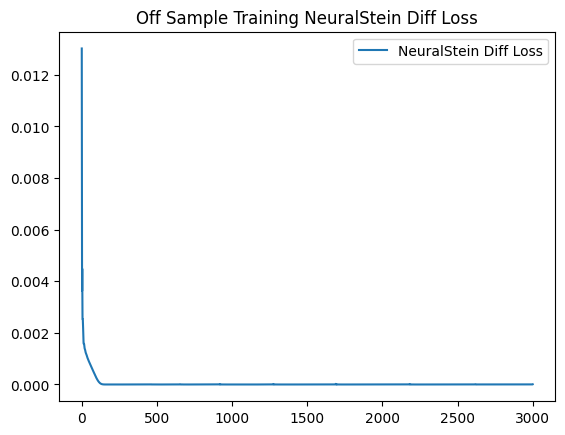

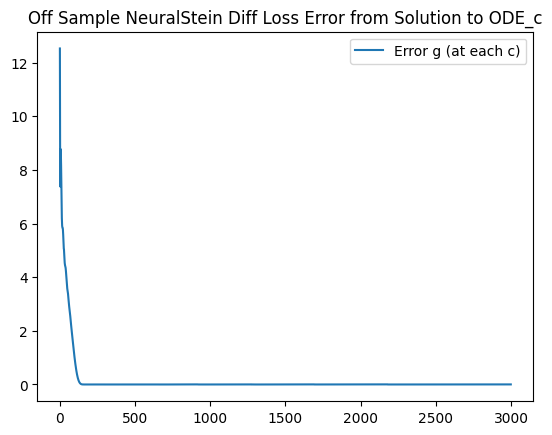

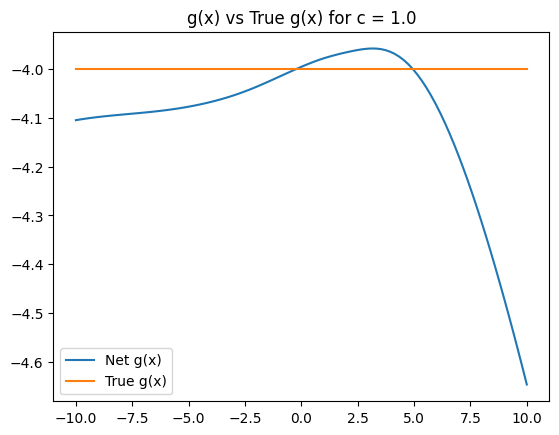

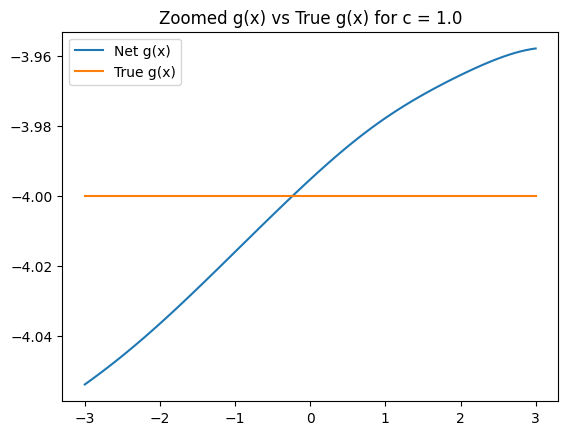

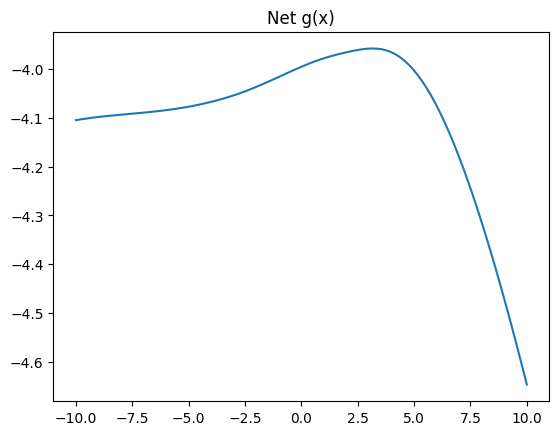

In [24]:
train(epochs = 3000, gt = False, type = "neural_stein")

### With multiparticle loss

In [16]:
train(gt = False, type = "neural_stein", multiparticle = True)

Training :   0%|          | 5/1000 [00:00<00:52, 18.89it/s]

Epoch [0/1000], Loss: 7.746953517198563e-05, Est Moment: -4.105449676513672, Error soln_c (on samples): 21.61395835876465


Training :   6%|▌         | 56/1000 [00:01<00:31, 29.66it/s]

In [41]:
# simultaneously training c with g - has no effect
# initializing c first, then training g to completion -> this effects convergence, instead of est_monet=  -4., it goes to est_moment ~= -1.0 
# still incorrect (with very low loss), but important clue


Training :   4%|▍         | 38/1000 [00:00<00:05, 186.48it/s]

Epoch [0/1000], Loss: 0.03729498147964477, Error g_c: 723.6749877929688, Est moment (Stein-val - h): 0.5964349508285522, MC est: 0.5946288108825684


Training :  14%|█▍        | 138/1000 [00:00<00:04, 194.70it/s]

Epoch [100/1000], Loss: 3.945413627661765e-06, Error g_c: 0.0022742529399693012, Est moment (Stein-val - h): 1.0005050897598267, MC est: 0.5946288108825684


Training :  24%|██▎       | 236/1000 [00:01<00:04, 182.52it/s]

Epoch [200/1000], Loss: 9.898880307446234e-08, Error g_c: 1.8307981008547358e-05, Est moment (Stein-val - h): 0.9999516010284424, MC est: 0.5946288108825684


Training :  33%|███▎      | 327/1000 [00:01<00:03, 174.06it/s]

Epoch [300/1000], Loss: 3.955462489102501e-08, Error g_c: 7.468749390682206e-05, Est moment (Stein-val - h): 0.9998723864555359, MC est: 0.5946288108825684


Training :  44%|████▎     | 437/1000 [00:02<00:03, 176.11it/s]

Epoch [400/1000], Loss: 2.7400294584367658e-08, Error g_c: 0.00011835428449558094, Est moment (Stein-val - h): 0.9998373985290527, MC est: 0.5946288108825684


Training :  53%|█████▎    | 531/1000 [00:02<00:02, 184.09it/s]

Epoch [500/1000], Loss: 2.4709593162697275e-08, Error g_c: 0.00012142489867983386, Est moment (Stein-val - h): 0.9998354315757751, MC est: 0.5946288108825684


Training :  62%|██████▏   | 624/1000 [00:03<00:02, 176.00it/s]

Epoch [600/1000], Loss: 2.3159402644523653e-08, Error g_c: 0.0001052660882123746, Est moment (Stein-val - h): 0.999847412109375, MC est: 0.5946288108825684


Training :  73%|███████▎  | 732/1000 [00:04<00:01, 173.34it/s]

Epoch [700/1000], Loss: 2.1710670807806308e-08, Error g_c: 8.529698970960453e-05, Est moment (Stein-val - h): 0.9998635649681091, MC est: 0.5946288108825684


Training :  83%|████████▎ | 832/1000 [00:04<00:00, 190.14it/s]

Epoch [800/1000], Loss: 2.0296142793085893e-08, Error g_c: 6.649611168541014e-05, Est moment (Stein-val - h): 0.9998807311058044, MC est: 0.5946288108825684


Training :  93%|█████████▎| 931/1000 [00:05<00:00, 182.10it/s]

Epoch [900/1000], Loss: 1.892573777695361e-08, Error g_c: 5.020311800763011e-05, Est moment (Stein-val - h): 0.9998978972434998, MC est: 0.5946288108825684


Training : 100%|██████████| 1000/1000 [00:05<00:00, 180.99it/s]


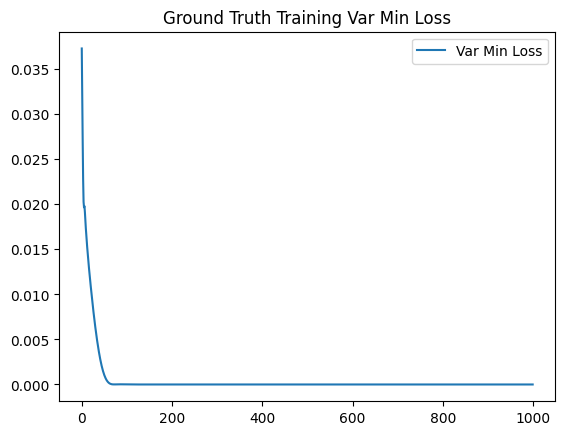

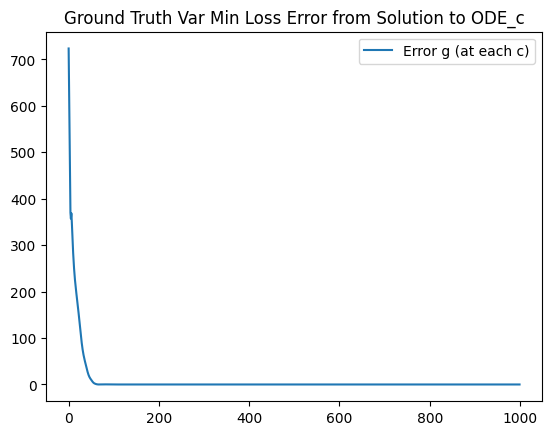

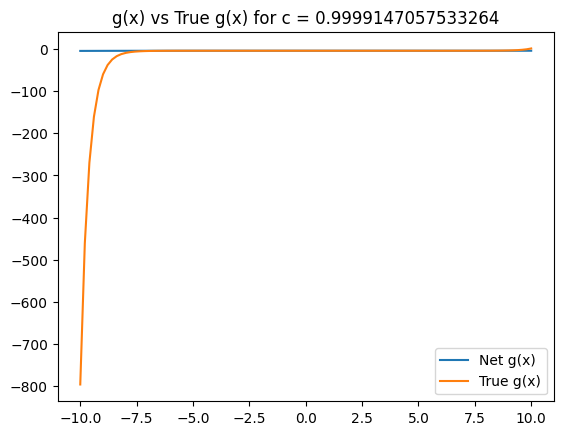

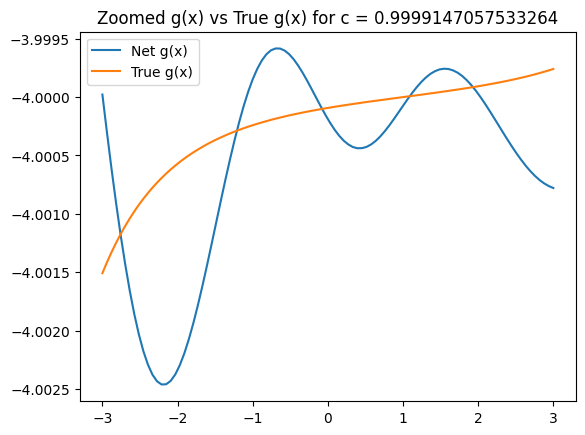

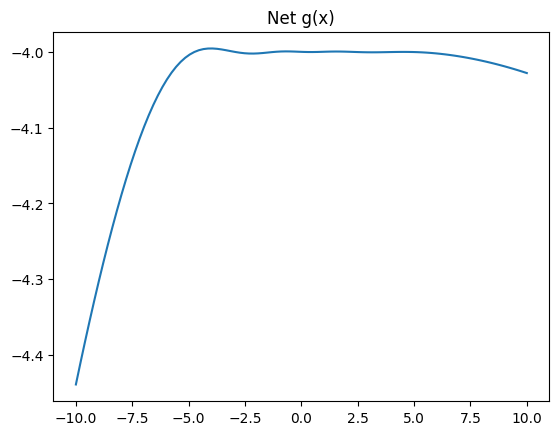

In [42]:
train(gt = True, var_min = True)

Training :   4%|▎         | 35/1000 [00:00<00:05, 169.91it/s]

Epoch [0/1000], Loss: 0.0402629280090332, Error g_c: 1091593788456960.0, Est moment (Stein-val - h): -4.44952392578125, MC est: -4.405371189117432


Training :  12%|█▎        | 125/1000 [00:00<00:05, 173.19it/s]

Epoch [100/1000], Loss: 3.548935754224658e-05, Error g_c: 176673546829824.0, Est moment (Stein-val - h): -1.1923696994781494, MC est: -4.405371189117432


Training :  24%|██▍       | 239/1000 [00:01<00:04, 189.39it/s]

Epoch [200/1000], Loss: 1.832678826758638e-06, Error g_c: 178737094066176.0, Est moment (Stein-val - h): -1.205135703086853, MC est: -4.405371189117432


Training :  34%|███▍      | 339/1000 [00:01<00:03, 192.78it/s]

Epoch [300/1000], Loss: 1.3057823525741695e-06, Error g_c: 177700866097152.0, Est moment (Stein-val - h): -1.1987342834472656, MC est: -4.405371189117432


Training :  44%|████▍     | 439/1000 [00:02<00:02, 195.00it/s]

Epoch [400/1000], Loss: 1.0313448001397774e-06, Error g_c: 176378284605440.0, Est moment (Stein-val - h): -1.1905369758605957, MC est: -4.405371189117432


Training :  52%|█████▏    | 518/1000 [00:02<00:02, 185.00it/s]

Epoch [500/1000], Loss: 7.895624003140256e-07, Error g_c: 175320799903744.0, Est moment (Stein-val - h): -1.1839605569839478, MC est: -4.405371189117432


Training :  63%|██████▎   | 629/1000 [00:03<00:02, 175.03it/s]

Epoch [600/1000], Loss: 5.802015584777109e-07, Error g_c: 174427765473280.0, Est moment (Stein-val - h): -1.1783910989761353, MC est: -4.405371189117432


Training :  72%|███████▏  | 720/1000 [00:03<00:01, 175.73it/s]

Epoch [700/1000], Loss: 4.0825787436915564e-07, Error g_c: 173661147365376.0, Est moment (Stein-val - h): -1.1735987663269043, MC est: -4.405371189117432


Training :  84%|████████▍ | 840/1000 [00:04<00:00, 193.10it/s]

Epoch [800/1000], Loss: 2.7556567147257735e-07, Error g_c: 173013915926528.0, Est moment (Stein-val - h): -1.1695446968078613, MC est: -4.405371189117432


Training :  94%|█████████▍| 940/1000 [00:05<00:00, 195.65it/s]

Epoch [900/1000], Loss: 1.7919517631526104e-07, Error g_c: 172481574862848.0, Est moment (Stein-val - h): -1.1662039756774902, MC est: -4.405371189117432


Training : 100%|██████████| 1000/1000 [00:05<00:00, 185.46it/s]


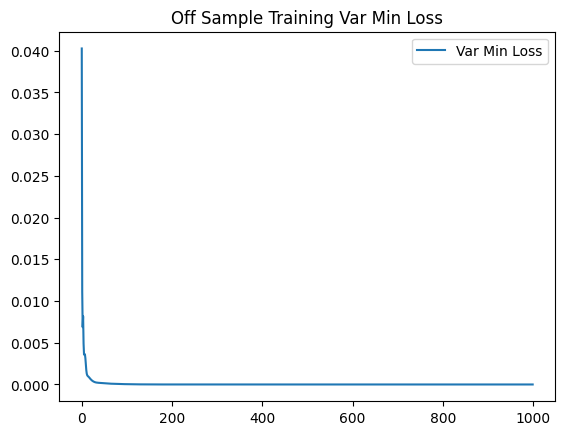

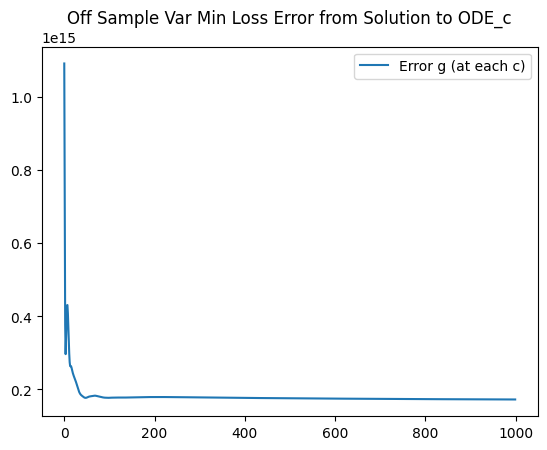

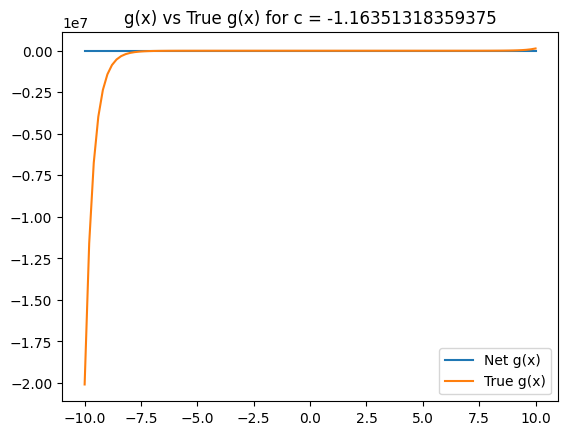

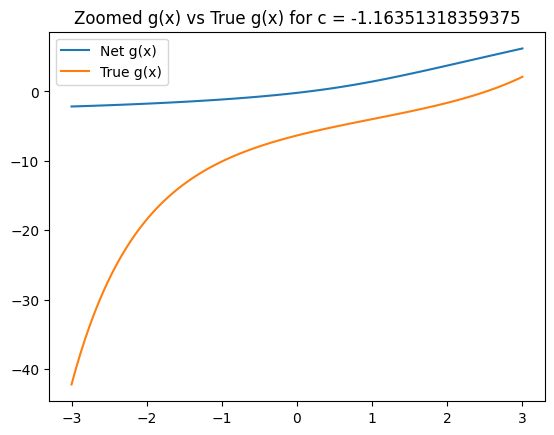

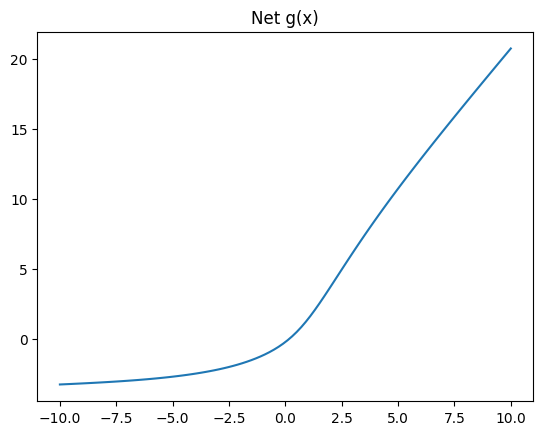

In [43]:
train(gt=False, var_min = True)

In [45]:
seed = 1

#set seeds for repro
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# sample from gaussian
samples = dist.sample((1000,1))
samples.requires_grad = True 

off_samples = torch.clone(samples.detach()) - 5.0
off_samples.requires_grad = True

net = network.MLP(n_dims=1, n_out=1)

sorted_samples = torch.sort(samples, dim = 0)[0]
sorted_off_samples = torch.sort(off_samples, dim = 0)[0]

stein_vals_g = neural_CV.stein_g(sorted_samples, net, logprob)
stein_vals_g_off = neural_CV.stein_g(sorted_off_samples, net, logprob)

Text(0.5, 1.0, 'g(x) initial')

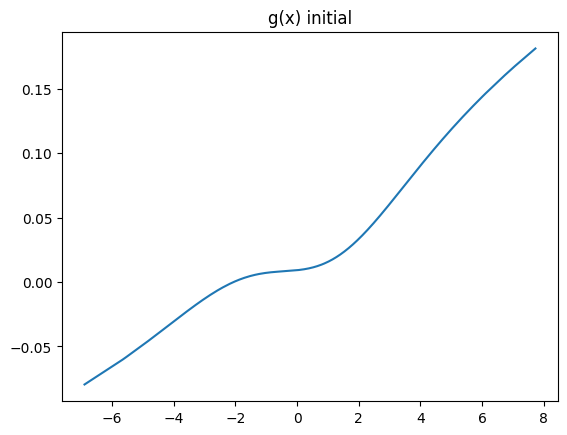

In [46]:
plt.plot(sorted_samples.detach().numpy(), net(sorted_samples).detach().numpy(), label = "g(x) initial")
plt.title("g(x) initial")

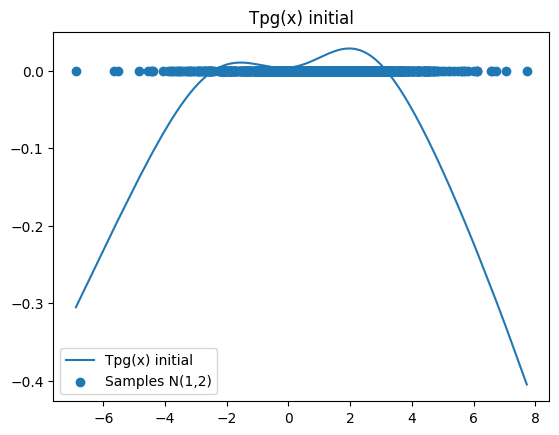

In [47]:
plt.plot(sorted_samples.detach().numpy(), stein_vals_g.detach().numpy(), label = "Tpg(x) initial")
plt.title("Tpg(x) initial")
plt.scatter(sorted_samples.detach().numpy(), [0.]*sorted_samples.size(0), label = "Samples N(1,2)")

plt.legend(loc='best')

In [48]:
stein_vals_g.mean()

tensor(-0.0014, grad_fn=<MeanBackward0>)

In [61]:
# check stability of solution true_g
cs = [-10., -5., -1., 0., 1., 5., 10.]

mesh_losses = []
samples_losses = []
p_mesh_losses = []
p_sample_losses = []
off_sample_losses = []
p_off_sample_losses = []

x = torch.linspace(-5,5,100).view(-1,1)
x.requires_grad = True

# set seeds for repro
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

samples = dist.sample((100,1))
samples.requires_grad = True 

off_samples = samples.detach() - 5.0
off_samples.requires_grad = True

perturbation = torch.randn_like(x)

for c in cs:

    def g(x):
        return true_g(x, c)

    def perturbed_g(x):
        return true_g(x, c) + 0.5 

    mesh_loss = ((neural_CV.stein_g(x, g, dist.log_prob) + c - integrand(x))**2).mean()
    sample_loss = ((neural_CV.stein_g(samples, g, dist.log_prob) + c - integrand(samples))**2).mean()
    off_sample_loss = ((neural_CV.stein_g(off_samples, g, dist.log_prob) + c - integrand(off_samples))**2).mean()

    #perturb stein_g and compute loss
    p_mesh_loss = ((neural_CV.stein_g(x, perturbed_g, dist.log_prob) + c - integrand(x))**2).mean() 
    p_sample_loss = ((neural_CV.stein_g(samples, perturbed_g, dist.log_prob) + c - integrand(samples))**2).mean()
    p_off_sample_loss = ((neural_CV.stein_g(off_samples, perturbed_g, dist.log_prob) + c - integrand(off_samples))**2).mean()

    print("\n c value ", c)
    print(f"Mesh loss: {mesh_loss}, Perturbed mesh loss: {p_mesh_loss}")
    print(f"Sample loss: {sample_loss}, Perturbed sample loss: {p_sample_loss}")
    print(f"Off sample loss: {off_sample_loss}, Perturbed off sample loss: {p_off_sample_loss}")

    mesh_losses.append(mesh_loss)
    samples_losses.append(sample_loss)
    p_mesh_losses.append(p_mesh_loss)
    p_sample_losses.append(p_sample_loss)
    off_sample_losses.append(off_sample_loss)
    p_off_sample_losses.append(p_off_sample_loss)


 c value  -10.0
Mesh loss: 4.571611422754529e-10, Perturbed mesh loss: 0.14846430718898773
Sample loss: 4.08058448142512e-10, Perturbed sample loss: 0.061787575483322144
Off sample loss: 0.018014276400208473, Perturbed off sample loss: 0.5927782654762268

 c value  -5.0
Mesh loss: 2.7071073160911396e-10, Perturbed mesh loss: 0.14846479892730713
Sample loss: 3.9667952256294825e-10, Perturbed sample loss: 0.06179514527320862
Off sample loss: 0.32091647386550903, Perturbed off sample loss: 0.8068627119064331

 c value  -1.0
Mesh loss: 1.629404597358608e-11, Perturbed mesh loss: 0.1484633982181549
Sample loss: 3.9198966295117543e-10, Perturbed sample loss: 0.06179960072040558
Off sample loss: 0.9347454905509949, Perturbed off sample loss: 1.425148367881775

 c value  0.0
Mesh loss: 2.4588909467576636e-12, Perturbed mesh loss: 0.1484639048576355
Sample loss: 5.751779608154095e-11, Perturbed sample loss: 0.06179756298661232
Off sample loss: 1.1369251012802124, Perturbed off sample loss: 1.6

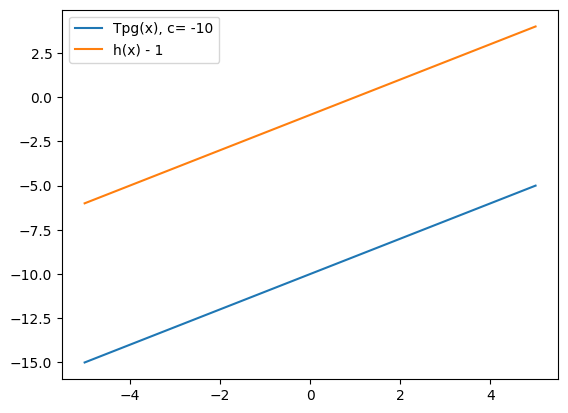

In [62]:
def g_10(x):
    return true_g(x, 10.)

def g_1(x):
    return true_g(x, 1.)

plt.plot(x.detach().numpy(), neural_CV.stein_g(x, g_10, logprob).detach().numpy(), label = "Tpg(x), c = -10")
plt.plot(x.detach().numpy(), integrand(x).detach().numpy() - 1., label = "h(x) - 1")
plt.legend(loc='best')

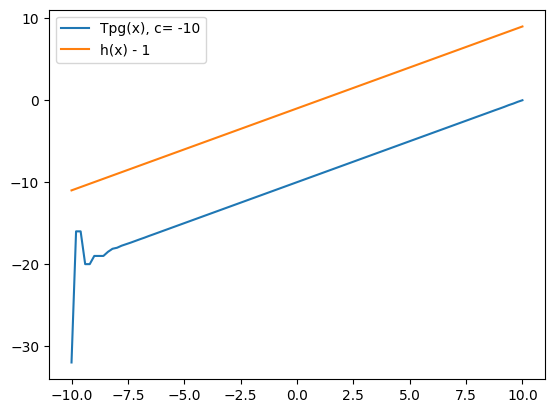

In [63]:
x_l = torch.linspace(-10,10,100).view(-1,1)
x_l.requires_grad = True

plt.plot(x_l.detach().numpy(), neural_CV.stein_g(x_l, g_10, logprob).detach().numpy(), label = "Tpg(x), c= -10")
plt.plot(x_l.detach().numpy(), integrand(x_l).detach().numpy() - 1., label = "h(x) - 1")
plt.legend(loc='best')

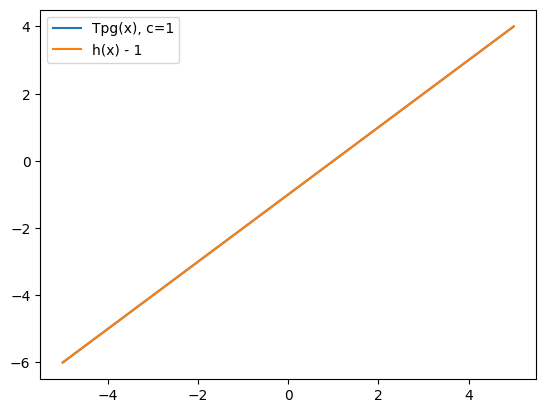

In [64]:
plt.plot(x.detach().numpy(), neural_CV.stein_g(x, g_1, logprob).detach().numpy(), label = "Tpg(x), c=1")
plt.plot(x.detach().numpy(), integrand(x).detach().numpy() - 1., label = "h(x) - 1")
plt.legend(loc='best')

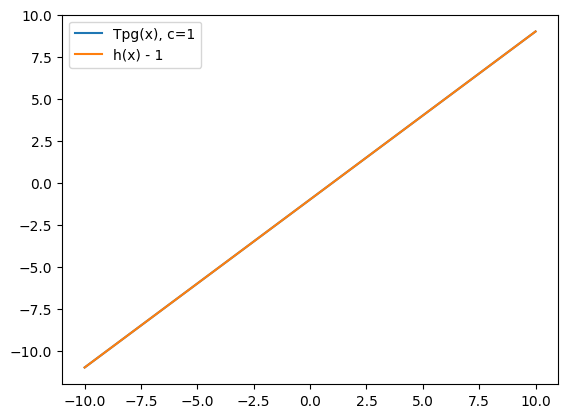

In [65]:
plt.plot(x_l.detach().numpy(), neural_CV.stein_g(x_l, g_1, logprob).detach().numpy(), label = "Tpg(x), c=1")
plt.plot(x_l.detach().numpy(), integrand(x_l).detach().numpy() - 1., label = "h(x) - 1")
plt.legend(loc='best')

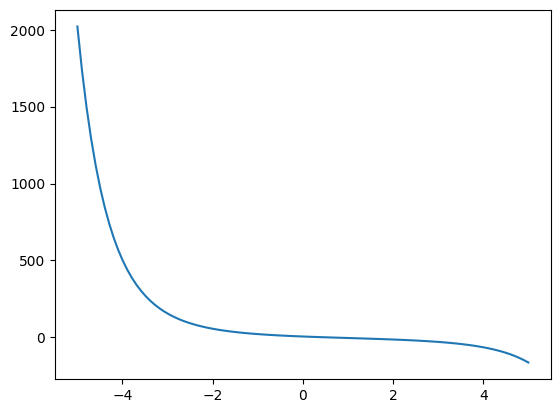

In [54]:
plt.plot(x.detach().numpy(), g(x).detach().numpy(), label = "g(x), c=1")